# Background construction

This notebook examines the background construction method and errors.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import parameters as param
import mpi4py.MPI as MPI
import uuid
%matplotlib notebook

In [13]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Dropbox/Projects/pg_coupling/hg/compressible/notebooks/parameters.py'>

In [14]:
domain, p_full, a_full = atmos.solve_hydrostatic_pressure(param, np.float64)
p_full, p, a_full, a, heq, N2 = atmos.truncate_background(param, p_full, a_full)

2018-11-05 17:35:41,859 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2018-11-05 17:35:42,171 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2018-11-05 17:35:42,174 atmospheres 0/1 INFO :: Perturbation norm: 2.969452684233013e-07
2018-11-05 17:35:42,376 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2018-11-05 17:35:42,379 atmospheres 0/1 INFO :: Perturbation norm: 1.803794625314551e-14


## Examine truncation accuracy

<IPython.core.display.Javascript object>


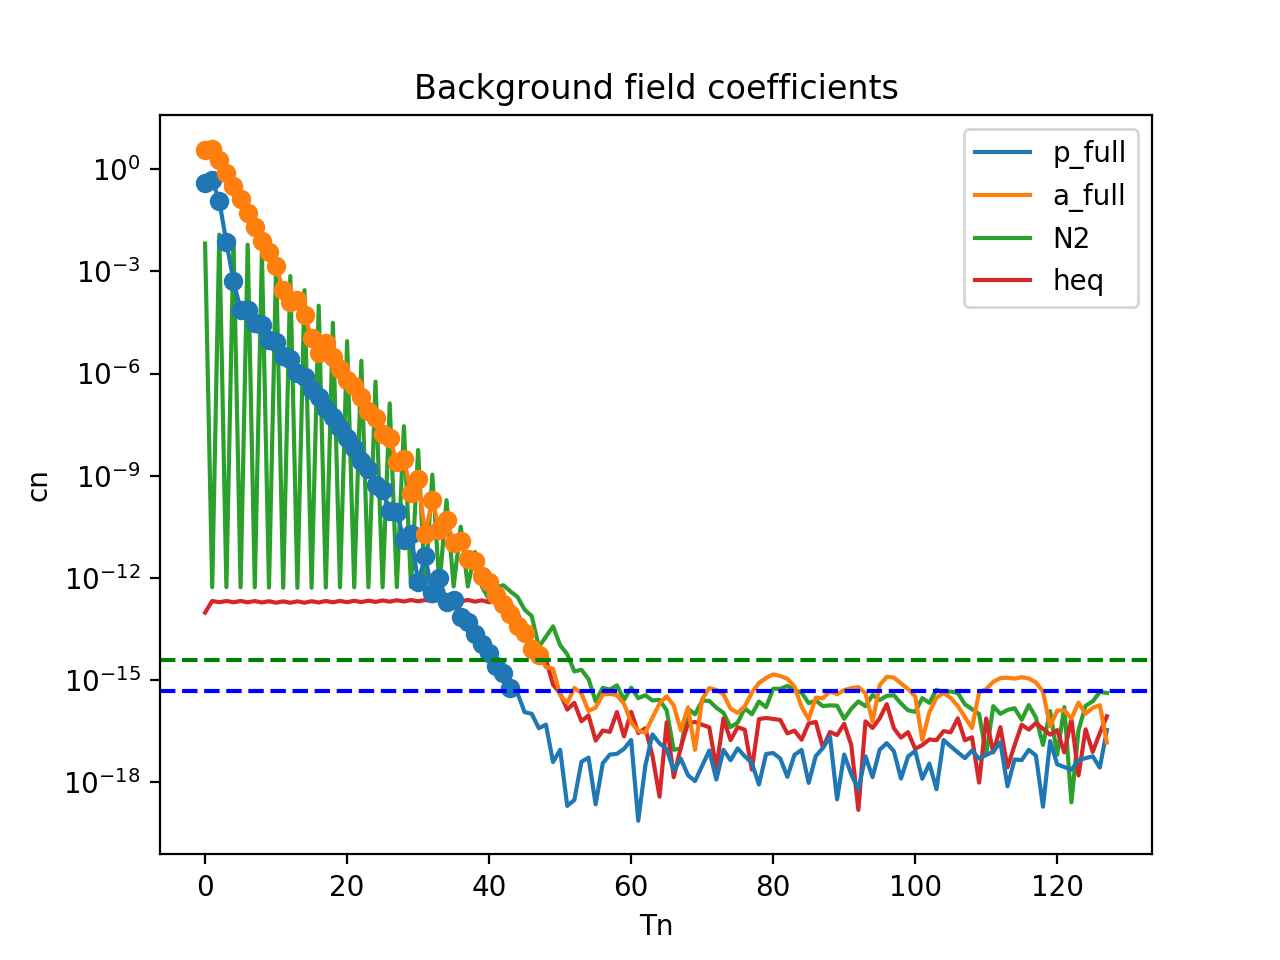

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  # Remove the CWD from sys.path while we load stuff.


In [15]:
# Plot coefficients
fig, axes = plt.subplots(1, 1)
axes.semilogy(np.abs(p_full['c']), '-', label='p_full')
axes.semilogy(np.abs(a_full['c']), '-', label='a_full')
axes.semilogy(np.abs(N2['c']), '-', label='N2', zorder=0)
axes.semilogy(np.abs(heq['c']), '-', label='heq', zorder=0)
axes.set_color_cycle(None)
axes.semilogy(np.abs(p['c']), 'o')
axes.semilogy(np.abs(a['c']), 'o')
axes.set_color_cycle(None)
axes.axhline(param.pressure_floor*np.max(np.abs(p_full['c'])), ls='dashed', c='b')
axes.axhline(param.background_floor*np.max(np.abs(a_full['c'])), ls='dashed', c='g')
axes.set_xlabel('Tn')
axes.set_ylabel('cn')
axes.set_title('Background field coefficients')
axes.legend(loc='upper right')

<IPython.core.display.Javascript object>


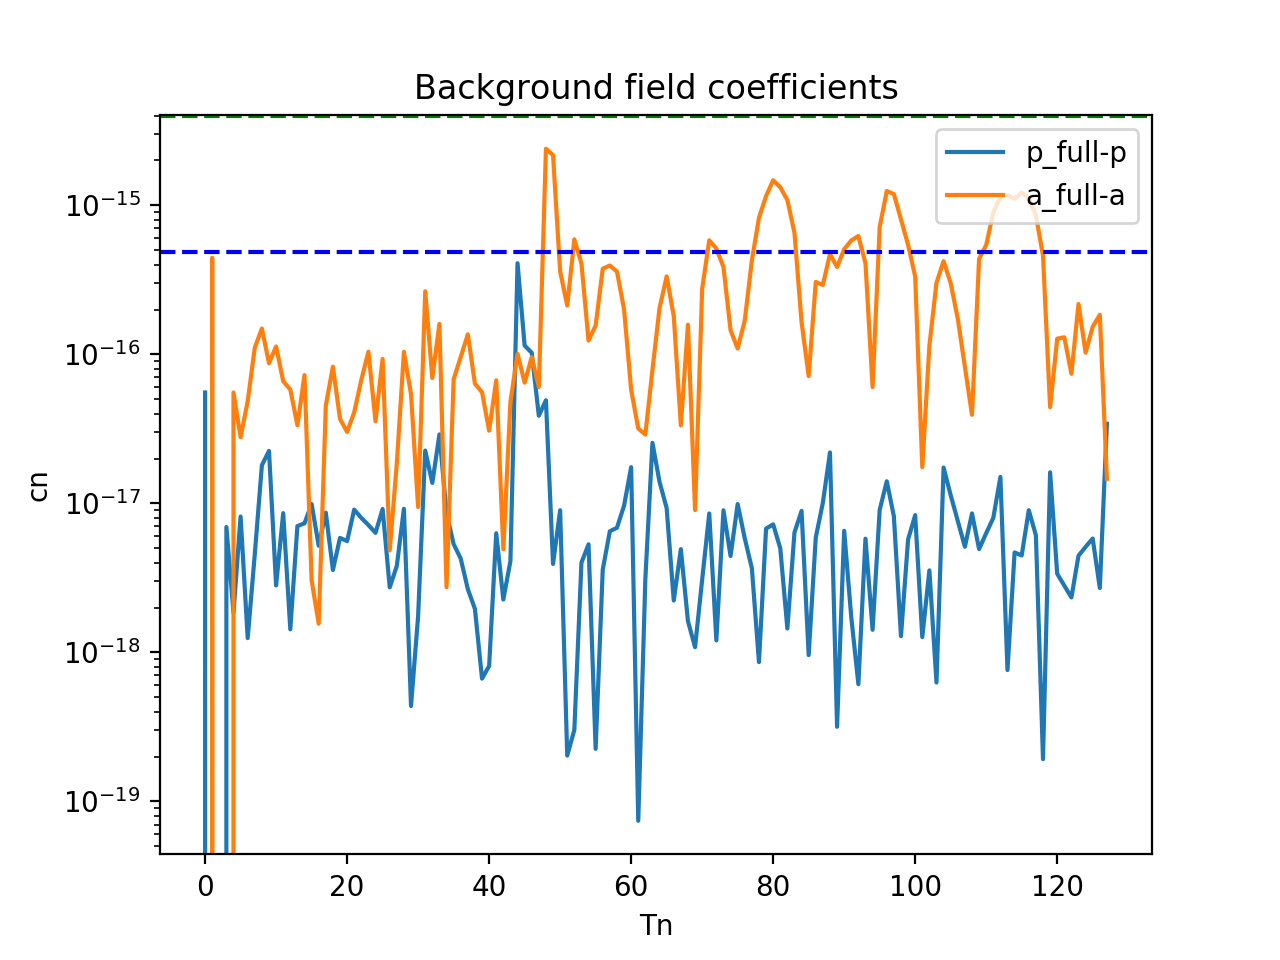

In [16]:
# Plot coefficient errors
fig, axes = plt.subplots(1, 1)
axes.semilogy(np.abs(p_full['c']-p['c']), '-', label='p_full-p')
axes.semilogy(np.abs(a_full['c']-a['c']), '-', label='a_full-a')
axes.axhline(param.pressure_floor*np.max(np.abs(p_full['c'])), ls='dashed', c='b')
axes.axhline(param.background_floor*np.max(np.abs(a_full['c'])), ls='dashed', c='g')
axes.set_xlabel('Tn')
axes.set_ylabel('cn')
axes.set_title('Background field coefficients')
axes.legend(loc='upper right')

<IPython.core.display.Javascript object>


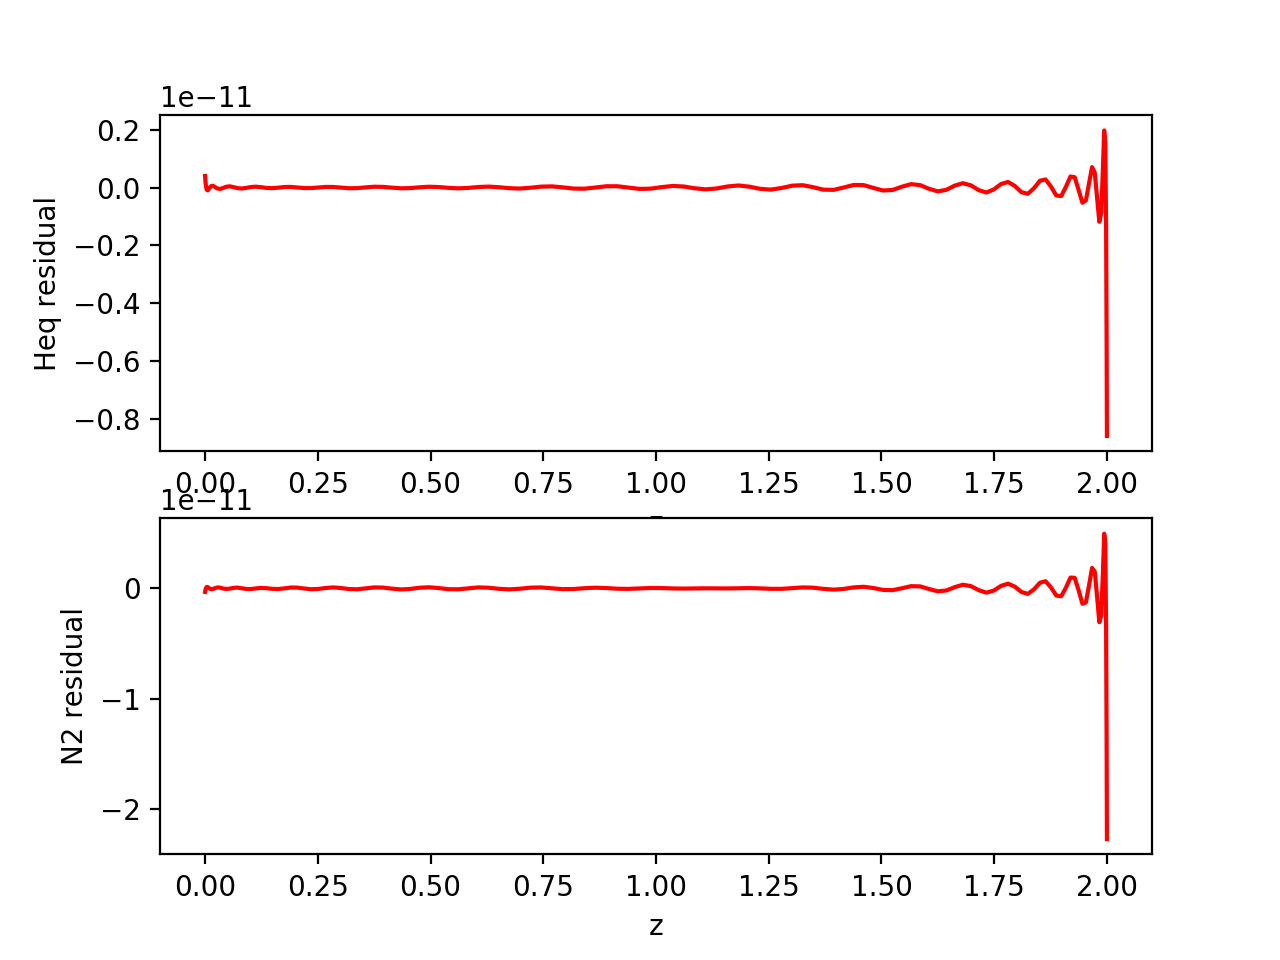

Heq Linf error: 8.56886674869053e-12
N2 Linf error: 2.2732657460548326e-11


In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Examine hydrostatic equilibrium residual
z = domain.grid(0)
heq.set_scales(1)
ax1.plot(z, heq['g'], '-r')
ax1.set_xlabel('z')
ax1.set_ylabel('Heq residual')
print('Heq Linf error:', np.max(np.abs(heq['g'])))

# Examine buoyancy frequency residual
N2_ref = param.N2_func(z)
N2.set_scales(1)
ax2.plot(z, N2['g']-N2_ref, '-r')
ax2.set_xlabel('z')
ax2.set_ylabel('N2 residual')
print('N2 Linf error:', np.max(np.abs(N2['g']-N2_ref)))

## Plot atmospheric structure

In [18]:
z = domain.grid(0)
# Pressure scale height
Hp = (a * p / param.g).evaluate()
# Adiabatic sound speed squared
cs2 = (param.γ * p * a).evaluate()
# Acoustic cutoff frequency
ωc = (cs2**0.5 / 2 / Hp).evaluate()
# Adiabat
g = param.g
γ = param.γ
p_ad = (1 - (γ-1)*z/γ)**(γ/(γ-1))

<IPython.core.display.Javascript object>


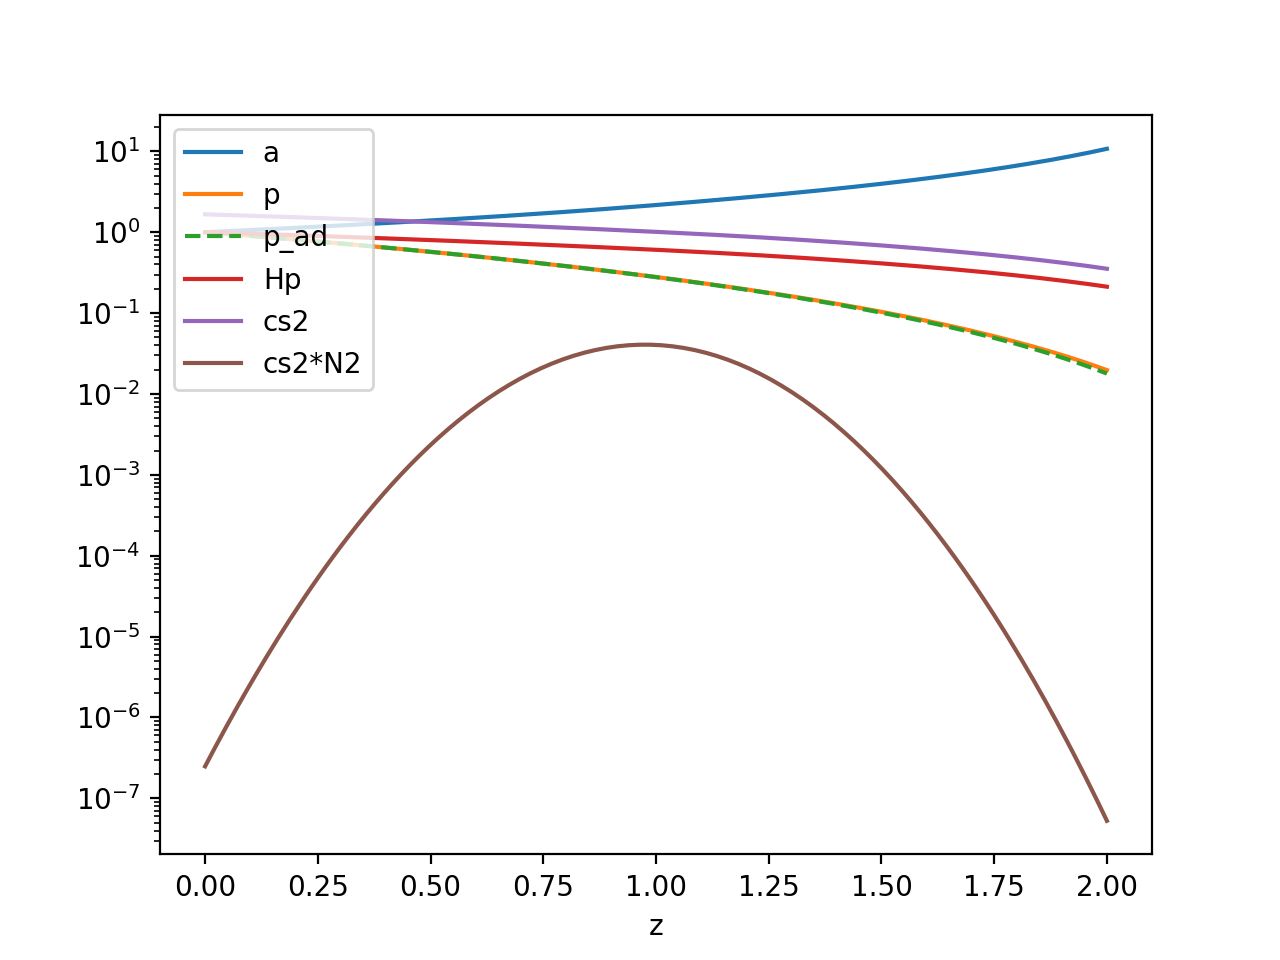

In [23]:
z = domain.grid(0)
fig, axes = plt.subplots(1, 1)
a.set_scales(1)
p.set_scales(1)
Hp.set_scales(1)
cs2.set_scales(1)
axes.plot(z, a['g'], label='a')
axes.plot(z, p['g'], label='p')
axes.plot(z, p_ad, '--', label='p_ad')
axes.plot(z, Hp['g'], label='Hp')
axes.plot(z, cs2['g'], label='cs2')
axes.plot(z, cs2['g']*N2['g'], label='cs2*N2')
axes.axhline(0, c='k')
axes.set_xlabel('z')
axes.set_yscale('log')
axes.legend(loc='upper left')

<IPython.core.display.Javascript object>


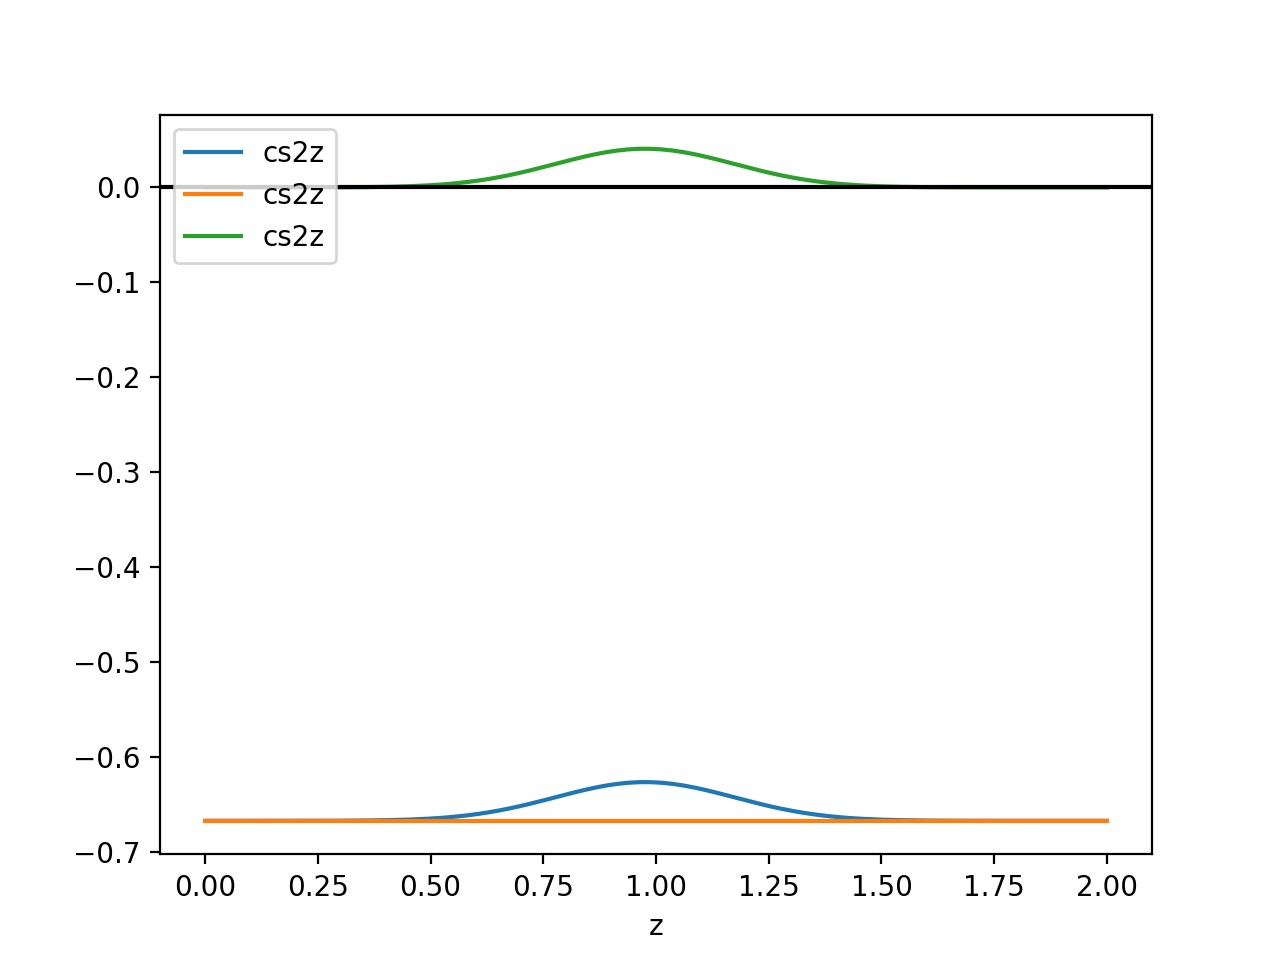

In [20]:
z = domain.grid(0)
fig, axes = plt.subplots(1, 1)

cs2z = cs2.differentiate('z')
cs2.set_scales(1)
cs2z.set_scales(1)
axes.plot(z, cs2z['g'], label='cs2z')
axes.plot(z, np.ones_like(z)*g*(1-γ), label='cs2z')
axes.plot(z, cs2['g']*N2['g']/g, label='cs2z')
axes.axhline(0, c='k')
axes.set_xlabel('z')
axes.legend(loc='upper left')

In [21]:
# Number of pressure scale heights
np.log(p['g'][-1]/p['g'][0])

-3.9257102361722134

<IPython.core.display.Javascript object>


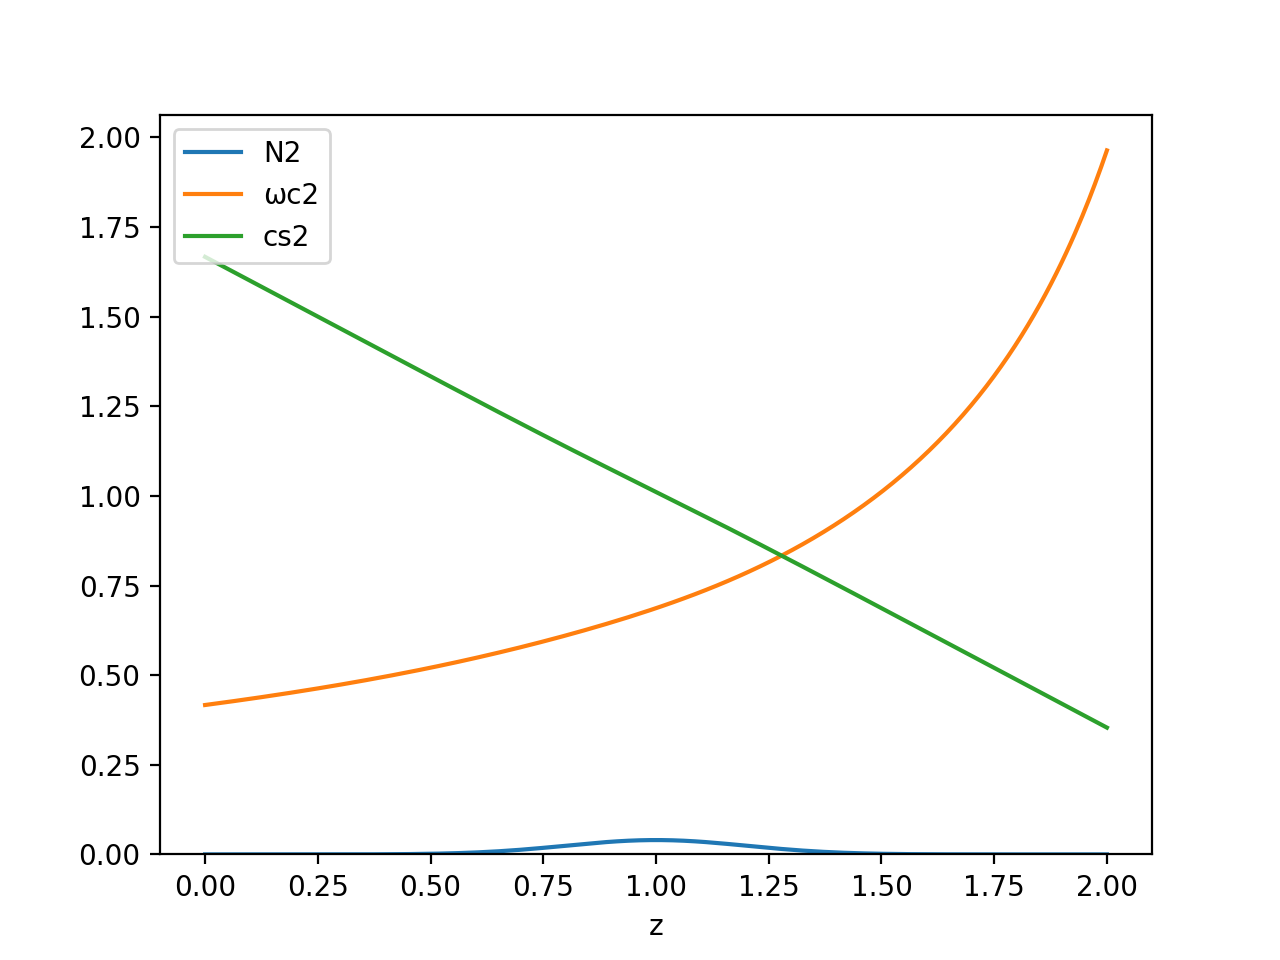

(0, 2.061806669957858)

In [24]:
fig, axes = plt.subplots(1, 1)
N2.set_scales(1)
ωc.set_scales(1)
axes.plot(z, N2['g'], label='N2')
#axes.plot(z, N2_ref**0.5, '--', label='Nr')
axes.plot(z, ωc['g']**2, label='ωc2')
axes.plot(z, cs2['g'], label='cs2')
axes.set_xlabel('z')
axes.legend(loc='upper left')
axes.set_ylim(0, None)